# <b>$$ Final Project $$</b>
## 0. [Preparation](#preparation)
## 1. [Introduction](#introduction)
## 2. [Literature Review](#literature-review)
## 3. [Exploratory Data Analysis](#eda)
## 4. [Methodology](#methodology)
## 5. [Discussion](#discussion)
## 6. [Moving Forward](#moving-forward)
## 7. [References](#references)

<a id='preparation'></a>
## Preparation

Set environment variables

In [1]:
ENV["COLUMNS"] = 500;
ENV["LINES"] = 100;

Primary libraries

In [2]:
using StatsKit
using RollingFunctions
using GLM
using ANOVA

Plotting libraries

In [3]:
using Plots
using StatsPlots

Support libraries

In [4]:
using Pipe

Load data

In [5]:
data = CSV.read("project_data_backup_2_26week.csv") |> DataFrame;
data2 = CSV.read("project_data_backup_2.csv") |> DataFrame;

In [6]:
cor_data = CSV.read("owid_correlation_table.csv") |> DataFrame;

Create control and treatment dataframes

In [7]:
df = by(data, [:country, :week], cases = :cases => sum, measures = :constraints => sum);

In [28]:
control = df[df.country .== "Sweden", :];
control2 = data2[data2.country .== "Sweden", :];

In [9]:
treatment = data[data.country .!= "Sweden", :];
treatment2 = data2[data2.country .!= "Sweden", :];

<a id='introduction'></a>
## Introduction

### Question: Have non-pharmaceutical interventions (NPIs) had an effect on SARS-CoV-2 transmission?
__$H_0$__: NPIs have no effect on COVID-19 transmission<br>
$H_A$: NPIs have some effect on COVID-19 transmission

### Variables
#### Dependent variable:
<li>cases (numerical) - new cases per million</li>

#### Independent Variables:
<li>week (numerical) - the week of the year</li>
<li>population (numerical) - number of people in the country</li>
<li>stringency_index (numerical) - Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)</li>
<li>constraints (categorical) - for NPIs which entailed physical restrictions, such as limitations to public gatherings or travel restrictions, a value of 1 is assigned. For re-openings and rollbacks of NPIs, -1. All other NPIs are assigned a value of zero.</li>

### Other Details
<li>Sample Size: n = 38</li>
<li>Original OWID dataset contained over 40 features. (Beltekian, 2020) </li>
<li>Original NPI dataset contained 9 features (Desvars-Larrive, 2020)</li>

<a id='literature-review'></a>
## Literature Review

1. American Society for Hematology
<ul>
- some evidence of severity related to blood type
- genetic components
</ul>
2. Two Articles (one authored by Bai, the other byHoward, et al.)
<ul>
- effectiveness of masks filtering breath</ul>
3. Volz et al.
<ul>
- evolution of SARS-CoV-2
- environment selecting for increased pathogenicity due to mask filtration
</ul>
4. Two Articles (one by Cho, one by Sweeney)
<ul>
- actions taken to track COVID-19
- potential detriments to human rights
</ul>

<a id='eda'></a>
## Exploratory Data Analysis

### Descriptive Statistics

#### Whole dataset

In [10]:
# last column is datatype
describe(data2, :all)[1:end-1]

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Nothing,Any,Any
1,continent,,,Asia,,,,South America,5,,Europe,Europe
2,country,,,Austria,,,,United States,38,,Austria,Slovenia
3,cases,24.7251,38.0541,0.0,0.917,8.99,33.945,679.823,,,0.0,0.0
4,stringency_index,52.5872,27.227,0.0,31.48,57.41,72.69,100.0,,,0.0,0.0
5,population,9.4256e7,1.25446e8,341250,6.8046e6,1.92377e7,1.26476e8,331002647,,,9006400,2078932
6,aged_65_older,16.7667,4.24902,4.652,15.413,16.984,19.436,27.049,,,19.202,19.062
7,aged_70_older,10.8477,3.5197,0.0,9.72,10.797,13.079,18.493,,,13.748,12.93
8,diabetes_prevalence,7.80405,2.79379,3.28,5.55,7.25,10.79,16.74,,,6.35,7.25
9,hospital_beds_per_thousand,4.19617,2.65418,0.7,2.61,2.96,5.609,13.05,,,7.37,4.5


#### By country

In [11]:
summary = by(data, :country) do data
    DataFrame(
        STD = std(data[:cases]),
        Var = var(data[:cases]),
        Min = minimum(data[:cases]),
        Mean = mean(data[:cases]),
        Median = median(data[:cases]),
        Max = maximum(data[:cases]),
        Total_Cases = sum(data[:cases]),
        Constraints = sum(data[:constraints])
    )
end

,country,STD,Var,Min,Mean,Median,Max,Total_Cases,Constraints
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,Austria,23.8894,570.701,0.0,21.0969,12.769,126.688,16814.2,294
2,Belgium,45.3524,2056.84,0.0,33.9475,15.445,201.56,11372.4,126
3,Bosnia and Herzegovina,6.57969,43.2923,0.0,7.45246,5.486,30.785,2548.74,142
4,Brazil,4.70738,22.1594,0.0,3.25637,1.091,33.958,1546.77,91
5,Canada,13.1709,173.472,0.0,9.03706,3.312,54.21,10239.0,539
6,Croatia,5.04062,25.4078,0.0,3.04586,0.731,23.385,1190.93,56
7,Czech Republic,9.55146,91.2305,0.0,7.51426,3.175,38.099,4621.27,161
8,Denmark,16.5472,273.809,0.0,19.8695,17.955,67.332,11524.3,119
9,Ecuador,62.2854,3879.47,0.0,15.8011,3.004,653.855,12925.3,175


#### Top 5 countries with most cases

In [12]:
top5 = first(sort(summary, :Total_Cases, rev=true), 5)

,country,STD,Var,Min,Mean,Median,Max,Total_Cases,Constraints
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,United States,35.6428,1270.41,0.0,37.712,25.556,146.612,281369.0,2898
2,Spain,57.0213,3251.43,0.0,68.6262,45.856,196.365,66704.7,329
3,Ireland,50.8591,2586.65,0.0,51.4462,44.352,236.745,48205.1,259
4,Switzerland,47.3604,2243.01,0.0,43.2515,24.496,160.608,35682.5,385
5,Netherlands,25.1075,630.388,0.0,31.4619,31.165,77.911,31241.7,259


#### Top 5 countries with the fewest cases

In [13]:
last(sort(summary, :Total_Cases, rev=true), 5)

,country,STD,Var,Min,Mean,Median,Max,Total_Cases,Constraints
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,Greece,2.89531,8.38279,0.0,2.33887,1.055,14.967,1045.48,238
2,Japan,0.935441,0.87505,0.0,0.452509,0.111,5.875,424.001,210
3,Mexico,1.74589,3.04812,0.0,1.0631,0.357,11.75,408.231,112
4,Thailand,0.850694,0.72368,0.0,0.608297,0.043,3.768,343.688,217
5,Honduras,1.48172,2.19551,0.0,0.9119,0.303,11.207,173.261,108


#### Control stats

In [14]:
DataFrame(
    Group = "Control",
    STD = std(control[:cases]),
    Var = var(control[:cases]),
    Min = minimum(control[:cases]),
    Mean = mean(control[:cases]),
    Median = median(control[:cases]),
    Max = maximum(control[:cases]),
    Total_Cases = sum(control[:cases]),
    Constraints = sum(control[:constraints])
)


,Group,STD,Var,Min,Mean,Median,Max,Total_Cases,Constraints
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,Control,16.4082,269.229,0.0,14.8259,10.001,79.115,7872.55,126


#### Treatment stats

In [15]:
DataFrame(
    Group = "Treatment",
    STD = std(treatment[:cases]),
    Var = var(treatment[:cases]),
    Min = minimum(treatment[:cases]),
    Mean = mean(treatment[:cases]),
    Median = median(treatment[:cases]),
    Max = maximum(treatment[:cases]),
    Total_Cases = sum(treatment[:cases]),
    Constraints = sum(treatment[:constraints])
)

,Group,STD,Var,Min,Mean,Median,Max,Total_Cases,Constraints
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,Treatment,36.0405,1298.92,0.0,23.8267,7.614,653.855,7.21828e5,10828


### Display country comparisons

The best data came from the first 18 weeks of 2020. After that, for various geopolitical reasons, accurate reports for NPIs became questionable around the world.

In [16]:
df = by(data, [:country, :week], cases = :cases => sum, constraints = :constraints => sum, population = :population => sum);
df2 = by(data, [:country], cases = :cases => sum);
sort!(df2, :cases, rev=true);
country_list = df2.country;

weeks = collect(1:length(unique(df.week)));

In [17]:
p = plot(layout=(7,1), size=(950,1750), fmt= :png)
counter = 1
sb = 1
for c in country_list
    if mod(counter, 6) == 0
        sb += 1
    end
    pd = df[df.country .== c, :]
    y = pd.cases
    plot!(weeks,y, label=c, reuse=true,
          ylabel="Cases",
          xlabel="Weeks", legend=:outertopright, subplot=sb,
          #yformatter=y->round(Int64, y÷100),
          title="Cases per million by country, highest to lowest, set $sb of 7")
    counter += 1
end

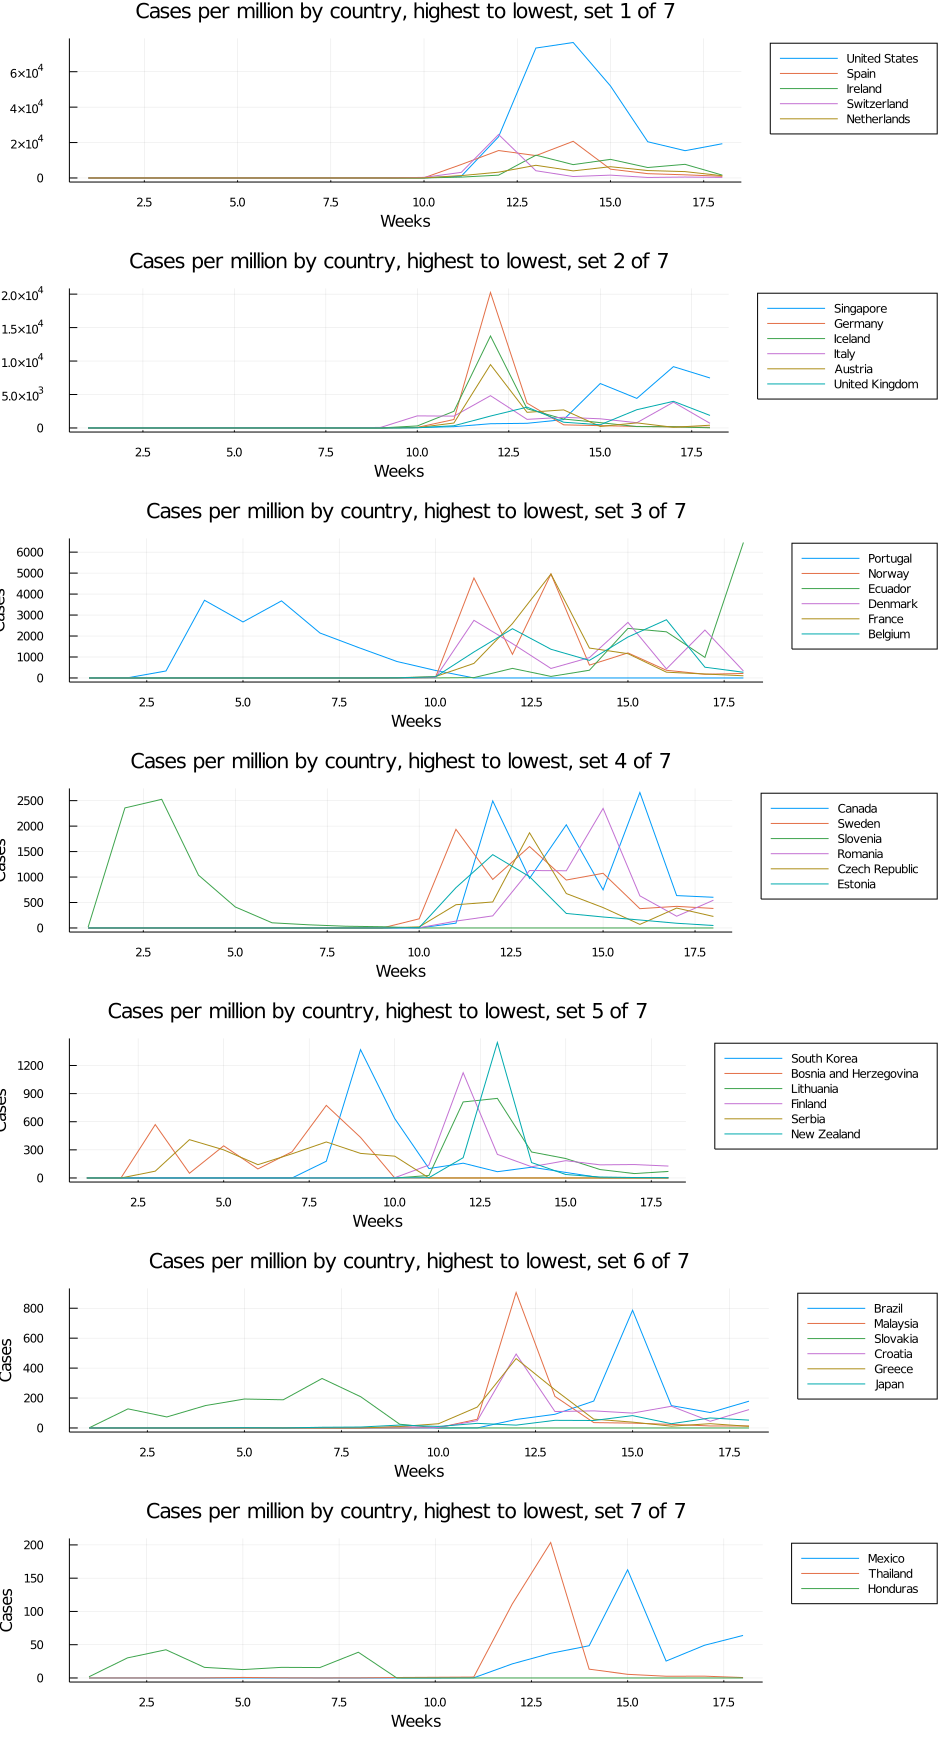

In [18]:
p

#### Look at control cases crossed with NPI implementations

In [30]:
y = control.cases;
x = control.week;
idx = findall(x->x > 0, control.constraints)
measures = control.week[idx];

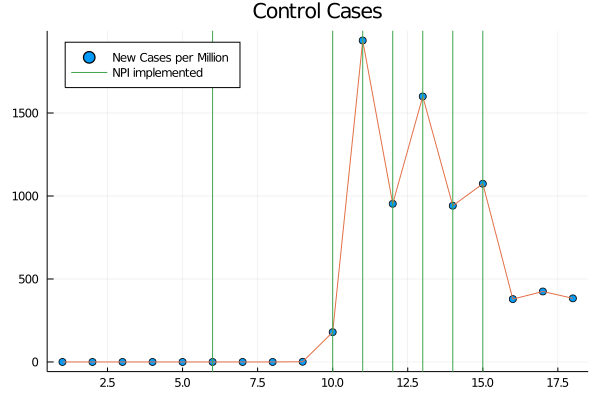

In [31]:
plot(x, y, leg=:topleft, lab="New Cases per Million", seriestype=:scatter)
plot!(x, y, lab=false)

vline!(measures, lab="NPI implemented")
title!("Control Cases")

#### Look at samples with most cases

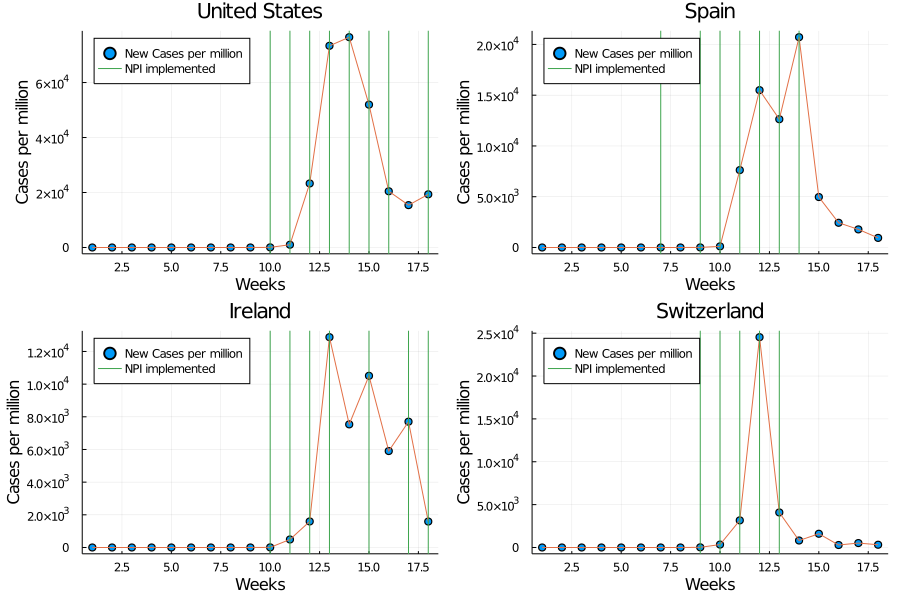

In [21]:
p = plot(layout=(2,2), size=(900,600))
for n = 1:4
    country = top5[1][n];
    trt = df[df.country .== country, :];
    idx = findall(x->x>0, trt.constraints);
    measures = trt.week[idx];
    
    scatter!(trt.cases, lab="New Cases per million", leg=:topleft, subplot=n)
    plot!(trt.week,trt.cases, lab=false, subplot=n)
    if length(measures) > 0
        vline!(measures, subplot=n, lab="NPI implemented") 
    end
    xlabel!("Weeks")
    ylabel!("Cases per million")
    title!(country, subplot=n)
end
p

Group new cases by week across treatment samples

In [22]:
spot = :cases
gdf_trt = by(treatment2, :week) do treatment2
    DataFrame(
        STD = std(treatment2[spot]),
        Min = minimum(treatment2[spot]),
        Mean = mean(treatment2[spot]),
        Median = median(treatment2[spot]),
        Max = maximum(treatment2[spot])
    )
    end;

In [23]:
spot = :cases
gdf_ctrl = by(control2, :week) do control2
    (  STD = std(control2[spot]),
        Var = var(control2[spot]),
        Min = minimum(control2[spot]),
        Mean = mean(control2[spot]),
        Median = median(control2[spot]),
        Max = maximum(control2[spot])
    )
    end;

#### Graph median cases per week with 7 day rolling average


In [24]:
window = 7
trtMedian = gdf_trt.Median;
trtMean = vcat(repeat([0], window-1), rollmedian(gdf_trt.Median,window));
ctrlMedian = gdf_ctrl.Median
ctrlMean = vcat(repeat([0],window-1),rollmedian(gdf_ctrl.Median, window));

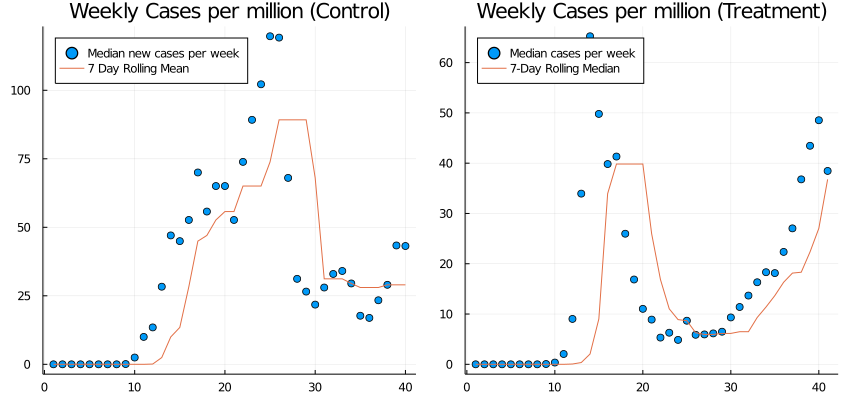

In [25]:
weeks = collect(1:maximum(gdf_trt.week))
p = plot(layout=(2), size=(850,400))
scatter!(trtMedian, label="Median cases per week", leg=:topleft, subplot=2)
plot!(weeks, trtMean, label="7-Day Rolling Median",subplot=2)
title!("Weekly Cases per million (Treatment)", subplot=2)


weeks2 = collect(1:maximum(gdf_ctrl.week))
scatter!(ctrlMedian, lab="Median new cases per week", leg=:topleft, subplot=1)
plot!(weeks2, ctrlMean, lab="7 Day Rolling Mean", subplot=1)
title!("Weekly Cases per million (Control)", subplot=1)

### Correlation Table, looking at new cases per million

In [33]:
sort(cor_data[:,[1,3]], :new_cases_per_million, rev=true)

,features,new_cases_per_million
,String,Float64
1,new_cases_per_million,1.0
2,new_deaths,0.338319
3,week,0.314481
4,new_deaths_per_million,0.226766
5,stringency_index,0.19174
6,population,0.169429
7,diabetes_prevalence,0.100477
8,extreme_poverty,0.0751931
9,gdp_per_capita,0.0640431


<a id='methodology'></a>
## Methodology

1. Acquire data from GitHub
2. Compare data. NPI list only includes 56 countries, 38 of which have NPIs annotated for at least 18 weeks
3. Reduce size of OWID dataset to align with NPI data
4. Merge datasets
5. EDA
6. Feature engineering
<ul>
- Add week column, extracted from dates<br>
- Eliminate redundancies
- Impute data as neccessary
- Handle missing data</ul>
7. Correlation table
<ul>
- Eliminate collinearities
</ul>
8. Select most correlated features
9. ANOVA
10. Regression

In [27]:
model = fit(LinearModel,
            @formula(cases ~ week + population + constraints + stringency_index),
            data,
            contrasts = Dict(:week => EffectsCoding(), :population => EffectsCoding(),:constraints => EffectsCoding(),
            :stringency_index => EffectsCoding()));

println("\nOLS\n")
println(model)
println("\n\nANOVA\n")
println(anova(model))
println("\n\nR-squared: ", r2(model))


OLS

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: cases ~ 1 + week + population + constraints + stringency_index

Coefficients:
──────────────────────────────────────────────────────────────
                      Estimate   Std.Error   t value  Pr(>|t|)
──────────────────────────────────────────────────────────────
(Intercept)       -23.5433      0.729123    -32.2899    <1e-99
week                2.16543     0.0865518    25.0189    <1e-99
population          3.07565e-8  1.34713e-9   22.8311    <1e-99
constraints        -4.36471     0.341004    -12.7996    <1e-36
stringency_index    0.383996    0.00986064   38.9423    <1e-99
──────────────────────────────────────────────────────────────


ANOVA

5×6 DataFrame
│ Row │ Source           │ DF        │ SS        │ MSS       │ F         │ p            │
│     │ String           │ Abstract… │ Abstract… │ Abstract… 

<a id='discussion'></a>
## Discussion

#### Bias
<li>Ascertainment bias</li>
<li>Regional bias</li>

#### Conclusion
<li>Reject $H_0$</li>
<li>Model on explains 25.9%</li>

#### Other Considerations
<li>Genetic factors (American Society of Hematology, 2020)</li>
<li>Problematic government responses (Cho, 2020)</li>
<li>Masks, social distancing, or both? (Howard, 2020)</li>

<a id='moving-forward'></a>
## Moving Forward

<li>Longer span of NPIs</li>
<li>More granular data: blood type, weather/climate, socioethnic composition </li>
<li>Time Series Analysis: ARIMA, Mann-Kendall</li>

<a id='references'></a>
## References

American Society of Hematology. (2020). <i>Studies Offer New Evidence for Possible Link Between Blood Type and COVID-19 Susceptibility and Severity.</i> Retrieved from https://www.hematology.org/newsroom/press-releases/2020/possible-link-between-blood-type-and-covid-19

Bai, N. (2020, October 15). <i>Still Confused About Masks? Here's the Science Behind How Face Masks Prevent Coronavirus.</i> https://www.ucsf.edu/news/2020/06/417906/still-confused-about-masks-heres-science-behind-how-face-masks-prevent.

Beltekian, D., Gavrilov, D., Hasell, J., Giattino, C., Macdonald, B., Mathieu, E.,... Roser, M. (Eds.). (2020). Owid/covid-19-data. https://github.com/owid/covid-19-data/tree/master/public/data/

Cho, A. (2020, May 14). <i>Artificial intelligence systems aim to sniff out signs of COVID-19 outbreaks.</i> https://www.sciencemag.org/news/2020/05/artificial-intelligence-systems-aim-sniff-out-signs-covid-19-outbreaks

Desvars-Larrive, A., Dervic, E., Haug, N. et al. <i>A structured open dataset of government interventions in response to COVID-19.</i> Sci Data 7, 285 (2020). https://doi.org/10.1038/s41597-020-00609-9

Howard, J., Huang, A., Li, Z., Vladimir, Z., van der Westhuizen, H.-M., von Delft, A., ... Rimoin, A. (2020). <i>Face Masks Against COVID-19: An Evidence Review.</i> San Francisco, CA. 

Sweeney, Y. <i>Tracking the debate on COVID-19 surveillance tools.</i> Nature Machine Intelligence 2, 301–304 (2020). https://doi.org/10.1038/s42256-020-0194-1

Volz, E. M. (2020, September 1). <i>Evaluating the effects of SARS-CoV-2 Spike mutation D614G on transmissibility and pathogenicity.</i> MedRxiv. https://www.medrxiv.org/content/10.1101/2020.07.31.20166082v2